## Human Centered Data Science
### Assignment A2  
Alyssa Goodrich  
November 2, 2017  

## Objective:  
The objective of this notebook is to explore the concept of bias by demonstrating that data can have variability of quality and quantity. To do this we will examine how politicians from various countries are covered on Wikipedia including quantity as well as quality of coverage. We will create four charts for this analysis including: 
- 10 highest-ranked countries in terms of number of politician articles as a proportion of country population
- 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
- 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
- 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country


## Data Sources Used
To create these charts, we will draw from three data sources, outlined below: 

**Source 1: Politicians by country from the English Language Wikipedia site.**This data includes:
1. "country", containing the sanitized country name, extracted from the category name;
2. "page", containing the unsanitized page title.
3. "last_edit", containing the edit ID of the last edit to the page.
It is available at the below website:
https://doi.org/10.6084/m9.figshare.5513449.v5
It is saved in the file: 'page_data.csv'  

**Source 2: Population by country**  This data includes:
Population, by country as of mid 2015
This data was downloaded from this website: http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14 
It is saved in the file: 'Population Mid-2015.csv'  

**Source 3: Predicted quality scores for articles for politicians from each country**  
This data includes quality scores generated by ORES for each article listed in source 1 above. We will access this data in the code below.  More information about ORES can be found here:
https://www.mediawiki.org/wiki/ORES
The ORES endpoint can be found here:
https://ores.wikimedia.org/v3/#!/scoring/get_v3_scores_context_revid_model
Licensing not listed, assuming licesnse of CC-BY-SA

## Key steps to complete analyses
In order to create this analysis we need to complete a series of steps that is summarized below and detailed throughout the document adjacent to the code that completes each step:
1. Download available data sets (Sources 1 and 2 above) 
2. Combine above datasets into a single data set that includes only articles and population data for countries that were present in both data sets above
3. Create an API call to extract quality score data from Source 3 above for each article present in the data set created in step 2 above
4. Output CSV of raw data into file called 'ArticleQuality.csv'
5. Create summary data by calculating fields necessary to conduct analyses including:
    - Number of articles per country
    - Population of country
    - Articles per million people
    - Number of FA or GA articles per country
    - Proportion of total articles that are FA or GA
6. Output CSV of summary data into file called 'CountrySummary.csv'
7. Filter data set to create lists of top ten and bottom ten quality and quantity
8. Create visualizations from top ten and bottom ten data



### Step 1: Extract data from available data sets (Sources 1  and 2 above) 
The data that is extracted in this step was downloaded from sources 1 and 2 above. In this step we are reading it in to our notebook so that we may access and analyze it. After importing it, we convert it to numpy array to facilitate analysis of the data.

In [47]:
import requests
import json
import csv
import numpy as np

#Read in politicians by country data that had been downloaded above. Save as numpy array

PageData = []
with open('page_data.csv', encoding = "utf8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        PageData.append([row[0],row[1],row[2],None])

PageData = np.array(PageData)
PageData[0,3] = 'Quality'


#Read in population data by country data that had been downloaded above. Save as numpy array for use in later analyses

PopulationData = [['country','Population']]
PopulationDict ={}
with open('Population Mid-2015.csv', encoding ='utf8') as csvfile:
    reader = csv.reader(csvfile)
    i = 0
    for row in reader:
        i += 1
        if (i >3): 
            PopulationData.append([row[0],int(row[4])])
            PopulationDict[row[0]]=int(row[4])
PopulationData = np.array(PopulationData)



### Step 2: Combine above datasets into a single data set that includes only articles and population data for countries that were present in both data sets above

We are only interested in countries where we have both the population and wikipedia article data. For this reason we will create a list of countries that are present in both data sets, and then create a data set that combines article data and population for countries present our data sets from both source 1 and source 2.

In [55]:
#Create an array of countries that are in both data sets
            
CountriesInBothDataSets = np.intersect1d(PopulationData[1:,0],PageData[1:,1])
        
# Create a single array with all the data fields that we need. Article quality will be empty until we pull it in the next step
#below.
CombinedData =  [['country', 'revision_id', 'article_quality', 'population']]
for i in range(len(PageData)):
    Country = PageData[i,1]
    if Country in CountriesInBothDataSets:
        CombinedData.append([PageData[i,1],PageData[i,2],None,PopulationDict[Country]])    


###  Step 3: Create an API call to extract quality score data from Source 3 above for each article present in the data set created in step 2 

In this step we extract the quality score for each article from the ORES API endpoint. We have structured the API call to request one article at a time and use the 'revid' variable to look up each article. Once we have extracted the score, we will insert the score into the data structure created in step 2. The potential scores and their meanings are as follows:
- FA - Featured article
- GA - Good article
- B - B-class article
- C - C-class article
- Start - Start-class article
- Stub - Stub-class article

In [106]:
#  This code was adapted from code supplied by Oliver Keyes and available at this url: http://hcds.yuvi.in/user/alyssacolony/notebooks/data-512-a2/NEW_hcds-a2-bias_demo.ipynb
endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}'
headers = {'User-Agent' : 'https://github.com/alyssacolony', 'From' : 'alcgood@uw.edu'}

params = {'project' : 'enwiki',
          'model' : 'wp10',
          'revid' : '797882120'
          }
# In this step we first extract the data from the API endpoint, and then store it in the empty spot in the data table that we created in step 2
for i in range(len(PageData)):
    revid = CombinedData[i+2][1]
    params['revid'] = revid
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    quality = response['enwiki']['scores'][revid]['wp10']['score']['prediction']
    CombinedData[i+1][2] = quality
    if i%100==0:
        print(i)



### Step 4: Output CSV of raw data into file called 'ArticleQuality.csv'
Here we store the interim data that we just extracted. It includes the following information for each article: 
- country: Country of politician that article is about
- revision_id: The ID number of the article, used to extract score	
- article_quality: Score extracted from ORES data base	
- population: Population of country 


In [74]:
file = open('ArticleQuality.csv', 'w',  newline='',encoding="UTF-8") 
writer = csv.writer(file)

# Extract necessary data and write to CSV
for line in CombinedData:
    writer.writerow(line)

file.close()

### Step 5: Create summary data by calculating fields necessary to conduct analyses
Here we calculte the fields necessary to conduct our analysis. They provide a summary for each country.
Fields include:  
- Number of articles per country
- Population of country
- Articles per million people
- Number of high quality articles per country, calculated as number of articles with a score of FA or GA 
- Ratio of high quality articles per thousand total articles




In [99]:
from collections import Counter
from collections import defaultdict
import collections

# Caluclate total articles per country using Counter fucntion
ArticlesPerCountry = Counter(np.array(CombinedData)[1:,0])

#Convert CombinedData into an numpy array for easier analysis
CombinedData = np.array(CombinedData)
SummaryDict = defaultdict(dict)

for country in ArticlesPerCountry:
    #Capture Country and calculate and record number of articles per country
    NumArticles = ArticlesPerCountry[country]
    SummaryDict[country]['NumberOfArticles'] = NumArticles
   
    #Capture and record population of country
    Population = PopulationDict[country]
    SummaryDict[country]['Population'] = Population
    
    #Caluclate Articles per million people
    ArtPerMillionPop = (NumArticles/Population)*1000000
    SummaryDict[country]['ArticlesPerMillionPeople'] = ArtPerMillionPop
    
    #Filter table to determine number of FA or GA articles per country, and capture result
    CountryArray = CombinedData[CombinedData[:,0]==country]
    QualityArray =CountryArray[(CountryArray[:,2]==('GA')) | (CountryArray[:,2]==('FA'))]
    NumQual = len(QualityArray)
    SummaryDict[country]['NumberOfQualityArticles'] = NumQual
    
    #Calculate proportion of total articles that are FA or GA
    NumQualPerThousArt = NumQual/NumArticles*1000
    SummaryDict[country]['QualityArticlesPerThousandArticles'] = NumQualPerThousArt




### Step 6: Output CSV of summary data into file called 'CountrySummary.csv'
Here we extract a summary of the data and save it to a CSV to enable future analysis. The fields we collected include the following infomration for each country.
- NumberOfArticles	
- Population	
- ArticlesPerMillionPeople	
- NumberOfQualityArticles	
- QualityArticlesPerThousandArticles  
This will be used in later analysis

In [95]:

# define headers
headers = ['Country',
           'NumberOfArticles',
           'Population',
           'ArticlesPerMillionPeople',
           'NumberOfQualityArticles',
           'QualityArticlesPerThousandArticles' ]

# Open file and initalize writer
file = open('CountrySummary.csv', 'w',  newline='') 
writer = csv.writer(file)
writer.writerow(headers)

# Create a dates variable to create a table ordered by dates
SortedCountries = collections.OrderedDict(sorted(SummaryDict.items()))
Countries = []
for item in SortedCountries:
    Countries.append(item)

# Extract necessary data and write to CSV
for Country in Countries:
    line = [Country]
    for header in headers[1:]:
            line.append(SummaryDict[Country][header])
    writer.writerow(line)

file.close()

### Step 7: Filter data to find top ten and bottom ten quality and quantity countries
We use the Pandas package to filter data to help us find the top ten and bottom ten countries on quality articles per thousand articles and total articles per million population. 

In [96]:
# Read data in from CSV and create a Pandas dataframe
import pandas as pd
SummaryData = pd.read_csv('CountrySummary.csv', index_col = 0)

#Sort data to find countries with lowest and highest quality and quantity of articles
QualitySort = SummaryData.sort_values(by=['QualityArticlesPerThousandArticles','NumberOfArticles'], ascending = [True,False])
QuantitySort = SummaryData.sort_values(by=['ArticlesPerMillionPeople','Population'], ascending = [True,False])

# Data Frame with countries with lowest quantity of articles
LowQuant = QuantitySort[:10] 

# Data Frame with countries with highest quantity of articles
HighQuant = QuantitySort[-10:]

#Data Frame with countries with lowest quality of articles
LowQual = QualitySort[:10]

#Data Frame with countries with highest quality of articles
HighQual = QualitySort[-10:]


### Step 8: Create visualizations from top ten and bottom ten lists created above
Here we create four bar charts to illustrate the variability in the quality of articles across countries. This is shown by charts creating charts for the top ten countries with the most articles per million people and the bottom ten countries with the fewest articles per million people.  We also illustrate the variability in quality with charts for the top ten countries with the most high quality articles per thousand total articles for the bottom ten countries with the fewest high quality articles per thousand total articles. 

In [78]:
import matplotlib.pyplot as plt
import pylab
%matplotlib inline  

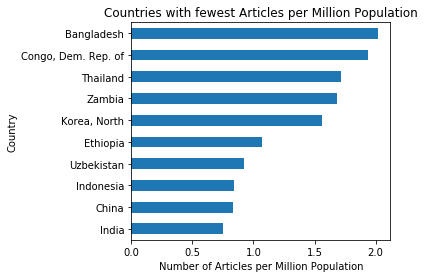

In [107]:
plt.figure();
plt.gcf().subplots_adjust(left=0.3)
axLowQuant = LowQuant['ArticlesPerMillionPeople'].plot.barh( title ="Countries with fewest Articles per Million Population"); 
axLowQuant.set_xlabel("Number of Articles per Million Population")

pylab.savefig('LowQuant.png')


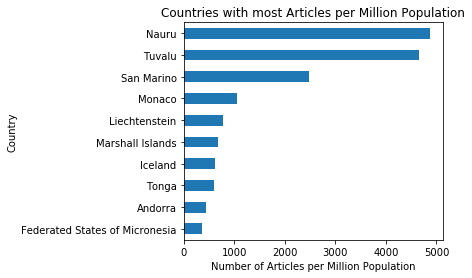

In [108]:
plt.figure();
plt.gcf().subplots_adjust(left=0.3)
axLowQuant = HighQuant['ArticlesPerMillionPeople'].plot.barh( title ="Countries with most Articles per Million Population"); 
axLowQuant.set_xlabel("Number of Articles per Million Population")

pylab.savefig('HighQuant.png')

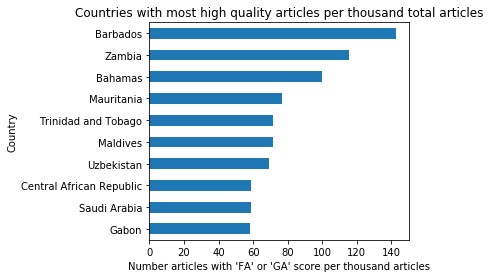

In [111]:
plt.figure();
plt.gcf().subplots_adjust(left=0.3)
axHighQual = HighQual['QualityArticlesPerThousandArticles'].plot.barh( title ="Countries with most high quality articles per thousand total articles"); 
axHighQual.set_xlabel("Number articles with 'FA' or 'GA' score per thousand articles")

pylab.savefig('HighQual.png')

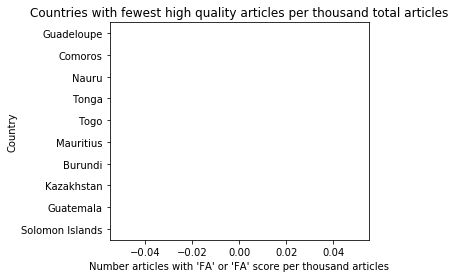

In [112]:
plt.figure();
plt.gcf().subplots_adjust(left=0.3)
axLowQuant = LowQual['QualityArticlesPerThousandArticles'].plot.barh( title ="Countries with fewest high quality articles per thousand total articles"); 
axLowQuant.set_xlabel("Number articles with 'FA' or 'FA' score per thousand articles")

pylab.savefig('LowQual.png')

Note: These countries each have zero high quality articles. They are the ten countries with the highest total number of articles while still showing zero articles with a 'FA' or 'GA' score.

## Reflection

This exercise helped illustrate the concept of bias in two ways. First, it helped highlight that there can be bias built in to data sets and it is important for researchers to be aware of this bias at a minimum, and ideally find a way to correct for it. Second, this exercise helped highlight for me the importance of understanding the bias that can be inherent in the measures which are used in the analysis. It is important to consider the context and implications of each measure rather than relying just on a single value of a measure in order to avoid biased conclusions. 

I will start with the first point. In conducting this exercise I created visualizations that revealed that the English wikipedia site does an inconsistent job at covering politicians across various countries. If a researcher were to rely solely on the English Wikipedia website as a data source when conducting research on politicians the outcome would be limited by the data that exist on that site. The analysis highlighted that some very deep disparities in coverage across countries. For example India had less than one article per million people, whereas Nauru had a rate of more than 4000 articles per million people (which is a little misleading because Nauru has only 10k people so it's 53 articles makes a very high rate). Likewise there was discrepancy in the quality of articles. For example a rate of more than 14 out of 1000 articles from the Barbados were high quality, while may other countries had zero articles that were high quality. These measures are not perfect (analysis of the use of these measures is coming up) but still they suggest variability in the depth of coverage of politicians across countries. This could perhaps be checked by comparing the number of quality articles against some other source that indicates numbers of politicians to find out which countries have the highest proportions of politicians covered by the English Wikipedia site.  

Now that we have determined that there is indeed variability in coverage, let's consider some of the biases that could result from that variability. One example is the country of Vanuatu. Vanuatu is a country with a somewhat high rate of high quality articles relative to total article count (With the old data it was one of the highest, but I still think the example illustrates a good point so I am going to keep using it). Although there are high quality articles for politicians in that country, there is a risk that those articles provide a biased view of the political climate. According to Vanuatu's Wikipedia site (https://en.wikipedia.org/wiki/Vanuatu) English is  one of three official languages of the country. The article indicates that "Government and society in Vanuatu tend to divide along linguistic French and English lines...Francophone politicians..tend to be conservative and support neo-liberal policies...The anglophone Vanua'aku Pati identifies as socialist and anti-colonial." It seems plausible that the English language Wikipedia site may be biased toward the anglophone politicians. While this is one example, surely there are other examples of hidden bias within the data that would only reveal themselves with detailed consideration.  A researcher who was unaware of these biases may draw incorrect conclusions. 

The second source of bias that this exercise illustrated for me was the bias that can come from using a measure that may result in biased findings.  We used number of articles as a proportion of total population as a proxy measurement for quantity of engagement and we used ratio of high quality articles as a proportion of total articles as a proxy measurement for quality of engagement. However, these measures provided a somewhat biased view if they are not considered in a broader context.

An example here is India. India was the country with the lowest number of articles per million people. Without considering the context a researcher could draw any number of conclusions about India's political engagement. However, when you look more deeply at the data you can see that India had 990 articles and its low rate relative to population is just due to its huge population. It seems unreasonable to expect that the number of articles would scale with the number of people. After all, regardless of population countries have only one president and/or prime minister. While more populous countries may tend to have more members in the legislative body, those bodies do not scale directly with population. The ten countries with the lowest rate of articles vs population have an average population of nearly 350M people, whereas the ten countries with the highest rate of articles vs population have an average population of only 80K. Clearly population causes a bias in the analysis leading high population countries to have a lower rate of articles. Similarly, the measure for quality tends to favor countries with few overall articles. The average number of articles for the countries with the highest proportion of quality articles is 48, while overall the average number of articles per country is 254. The countries with the highest proportion of quality articles averaged just 3.8 quality articles each, which is lower than the overall average of 6. 

The point is that it is important to consider potential biases introduced by the measures that are used to support conclusions. If one measure is biased it is important to at least be aware, but hopefully either find a way to adjust or find some additional measures to augment the analysis and reduce the impact of the bias. 